# Homework set 3

(Due Mar 3., 2023 at Noon)

Submit your solution notebook in your directory via github PR.

## Problem 1 (100 pts)

Our Colloquium speaker a couple of weeks ago, Ashley Villar, has had to use MCMC extensively. She had something like 5,243 objects from Pan-STARRS to analyze after all (https://zenodo.org/record/3974950)

You'll only have to deal with two - the two that are in this directory

In [1]:
!ls *snana.dat

PS1_PS1MD_PSc000098.snana.dat PS1_PS1MD_PSc000174.snana.dat


She used equation 1, defined here: https://arxiv.org/abs/1905.07422

# $ F= \begin{cases}\frac{A+\beta\left(t-t_0\right)}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t<t_1 \\ \frac{\left(A+\beta\left(t_1-t_0\right)\right) e^{-\left(t-t_1\right) / \tau_{\text {fall }}}}{1+e^{-\left(t-t_0\right) / \tau_{\text {rise }}}} & t \geq t_1\end{cases} $

to model the *flux*, $F$, of a supernova in some band, at times, $t$.

You can see the fits Ashley derived here:

<img src="examples.jpg">

As Bayesian's we have 4 questions to answer

    What's the model?
    What's the Likelihood?
    What's the Prior?
    How do you sample?

I've tell you 1 (eqn. 1 in Villar). and you've already guessed 4 (use `emcee`: https://emcee.readthedocs.io/en/stable/). 

Write some functions to implement the model, likelihood and priors, and use `emcee` to sample the posterior with 20 walkers and however many steps you feel is necessary for the burn-in and chain. (50 pts - 15 each for the model, likelihood, priors and 5 to sample) 
 
Show that the posterior is reasonable by generating a corner plot with the `corner` package. (10 pts)

Get the median estimate for each parameter, and recreate the plot above from Ashley. Note that she's made 5 random draws from the chain for each passband to give the reader a sense for the uncertainties. (25 pts)

Report the auto-correlation length of your chain. Thin it by a factor of 10 and report the auto-correlation length again. (15 pts)

In [2]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import emcee
import corner
import astropy.table as at
import scipy.optimize as so
import warnings
import pandas
warnings.simplefilter('ignore') # stop whining about RuntimeWarnings...

In [3]:
# the easiest way to read the files is just look at them in a text editor
# and get the columns you need - in this case, the header has useful info, but we're not including it in the model
# so we'll just skip it

cols = ['crap','MJD','FLT','FIELD','FLUXCAL','FLUXCALERR','MAG','MAGERR']
exclude_names = ['crap', 'FIELD']
object_names = ['SN098', 'SN174']
sn098 = at.Table.read('PS1_PS1MD_PSc000098.snana.dat', format='ascii',\
                      names=cols, exclude_names=exclude_names, data_start=18, data_end=-1)
sn174 = at.Table.read('PS1_PS1MD_PSc000174.snana.dat', format='ascii',\
                      names=cols, exclude_names=exclude_names, data_start=18, data_end=-1)
sn098

MJD,FLT,FLUXCAL,FLUXCALERR,MAG,MAGERR
float64,str1,float64,float64,float64,float64
55203.6,g,902.604,25.486,-12.389,0.031
55209.6,g,957.489,12.279,-12.453,0.014
55212.6,g,872.977,14.896,-12.353,0.019
55215.6,g,796.478,21.253,-12.253,0.029
...,...,...,...,...,...
56456.3,z,46.901,27.163,-9.178,0.629
56459.3,z,19.229,26.18,-8.21,1.478
56681.6,z,-9.721,25.122,nan,-2.806
56754.4,z,21.699,26.886,-8.341,1.345


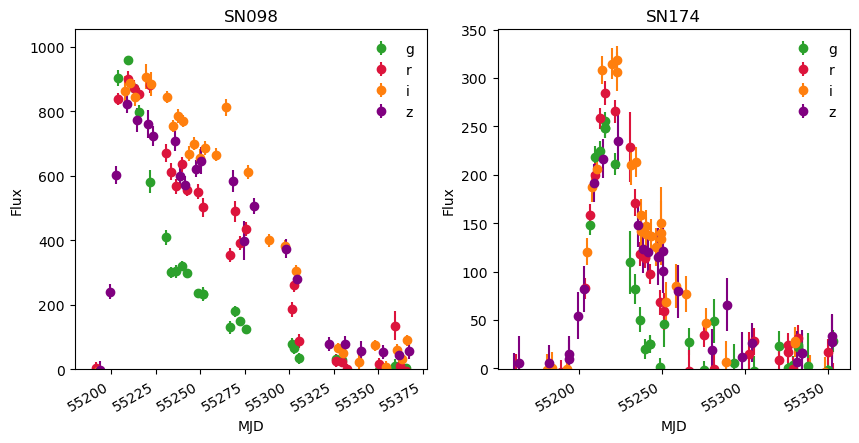

In [4]:
# look at your data and make sure it is reasonable

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(ncols=2)
# just setting up the same passband->color mapping that Ashley used
uniq_filts = {'g':'C2', 'r':'crimson', 'i':'C1', 'z':'purple'}

for sn, ax, name in zip([sn098, sn174], axs, object_names):
    for filt, color in uniq_filts.items():
        indf = sn['FLT'] == filt
        ax.errorbar(sn['MJD'][indf], sn['FLUXCAL'][indf], yerr=sn['FLUXCALERR'][indf],\
                    marker='o', color=color, linestyle='None', label=filt)

    # let's just zoom in on the relevant data
    indmax = sn['FLUXCAL'].argmax()
    mjdmax = sn['MJD'][indmax]
    indshow = (sn['MJD'] > mjdmax-180) & (sn['MJD'] <= mjdmax+180)
    minmjd = sn['MJD'][indshow].min()
    maxmjd = sn['MJD'][indshow].max()
    ax.set_xlim(minmjd-10, maxmjd+10)
    ax.set_ylim(-1, 1.1*sn['FLUXCAL'][indmax])
    
    # add our axes decoration
    ax.legend(loc='upper right', frameon=False)
    ax.set_title(name)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
fig.autofmt_xdate()

In [5]:
# 1a What is the model (15 pts)
# note that the Villar paper reparameterizes t1-t0 as gamma because it's more numerically stable
# I don't find that for these two objects, so I'm not bothering
ndim = 6
def villar_model(A, beta, t0, t1,  tau_rise, tau_fall, t=None):
    F = np.zeros(len(t))
    indt = t < t1
    F[indt]  = (A + beta*(t[indt] - t0))/(1. + np.exp(-(t[indt]-t0)/tau_rise))
    F[~indt] = ((A + beta*(t1-t0))*np.exp(-(t[~indt] - t1)/tau_fall))/(1. + np.exp(-(t[~indt]-t0)/tau_rise))
    return F

In [6]:
# we'll define a (reduced) chisq function for convenience
def chisq(x, *args):
    A, beta, t0, t1, tau_rise, tau_fall = x
    t, y, dy = args
    mod = villar_model(A, beta, t0, t1,  tau_rise, tau_fall, t=t)
    chisq = np.sum(((y - mod)**2.)/(dy**2.))/(len(t) - ndim)
    return chisq 
    
# and a log likelihood function for Emcee
# note that Emcee really does want the actual honest to goodness likelihood
# not reduced chi-squared, so I multiply by the number of degrees of freedom
# otherwise the likelihood and prior would not have the right
# relative normalization
def LogLikelihood(A, beta, t0, t1, tau_rise, tau_fall, t, y, dy):
    x = (A, beta, t0, t1,  tau_rise, tau_fall)
    args = (t, y, dy)
    negLogLike = chisq(x, *args)*(len(t) - ndim)
    return -negLogLike/2.

SN098 g 325.30 10.96 55150.95 55209.18 0.50 28.07 True
SN098 r 538.07 30.97 55193.93 55208.81 0.50 54.70 True
SN098 i 901.54 -4.16 55205.95 55282.01 0.50 26.43 True
SN098 z 820.23 -4.25 55200.98 55295.49 1.52 21.01 True
SN174 g 369.64 -11.37 55208.37 55239.17 3.94 93.77 True
SN174 r 384.50 -8.75 55208.71 55245.13 3.73 41.75 True
SN174 i 474.64 -11.66 55210.47 55237.50 4.58 34.22 True
SN174 z 267.05 -3.60 55205.01 55270.70 3.42 200.00 True


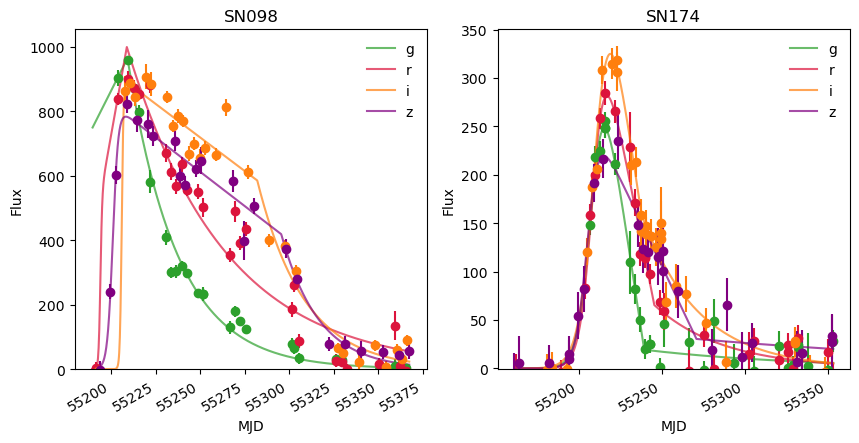

In [7]:
# A, Beta, t0, t1, tau_rise, tau_fall
# guesses here are your responsibility but also not actually critical 
# A is the peak flux roughly
# Beta is a slope
# t0 is time of maximum roughly
# t1 is the time of plateau onset - will matter for one of the two objects
# tau_rise is the rise time
# tau_fall is the fall time
# this is described in the para under the equation in Ashley's paper
guess = [300, 0, 55200, 55250,  15, 15]

# we'll set some very loose bounds on each parameter
bounds = [(10, 1000), (-50, 50), (55150, 55300), (55150, 55350), (0.5, 200), (0.5, 200)]

fig = plt.figure(figsize=(10, 5))
axs = fig.subplots(ncols=2)
results = {}

for sn, ax, name in zip([sn098, sn174], axs, object_names):
    results[name] = {}
    # let's just zoom in on the relevant data - this time for fitting really 
    indmax = sn['FLUXCAL'].argmax()
    mjdmax = sn['MJD'][indmax]
    indshow = (sn['MJD'] > mjdmax-180) & (sn['MJD'] <= mjdmax+180)
    minmjd = sn['MJD'][indshow].min()
    maxmjd = sn['MJD'][indshow].max()
    ax.set_xlim(minmjd-10, maxmjd+10)
    ax.set_ylim(-1, 1.1*sn['FLUXCAL'][indmax])
    
    # setup an array of times on which to plot the model 
    tarr = np.linspace(minmjd, maxmjd, 1000)
    
    for filt, color in uniq_filts.items():
        indf = sn['FLT'][indshow] == filt
        
        # we need to pass the data to scipy.optimize
        args = (sn['MJD'][indshow][indf], sn['FLUXCAL'][indshow][indf], sn['FLUXCALERR'][indshow][indf])
        res = so.minimize(chisq, guess, args=args, bounds=bounds)
        
        # we'll save and print the results so we can use these as starting guesses for the MCMC
        results[name][filt] = res
        print(name, filt, ' '.join(['%.2f'%x for x in res.x]), res.success)
        
        # plot the data again
        ax.errorbar(sn['MJD'][indshow][indf], sn['FLUXCAL'][indshow][indf], yerr=sn['FLUXCALERR'][indshow][indf],\
                    marker='o', color=color, linestyle='None')
        
        # we'll only plot if the fit was OK
        if res.success:
            # get the model 
            f = villar_model(*res.x, t = tarr)
            ax.plot(tarr, f, color=color, linestyle='-', marker='None', alpha=0.7, label=filt)
    
    # add our axes decoration
    ax.legend(loc='upper right', frameon=False)
    ax.set_title(name)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
fig.autofmt_xdate()

## Notice that the result for tau_rise is at the corner of our range for g, r, i of SN098
## This is likely because there's no points at all in the rise of those three bands
## The rise time is therefore not well constrained - z - which does have observations is fine

In [8]:
#1b Next we need the prior

def LogPrior(A, beta, t0, t1, tau_rise, tau_fall, args=None):
    
    # we can put some big bounds on the parameters
    if (A < 10  or A > 1000) or\
        (beta < -50 or beta > 50)  or\
        (t0 < 55150 or t0 > 55300) or\
        (t1 < 55150 or t1 > 55300) or\
        (tau_rise < 0.1 or tau_rise > 200) or\
        (tau_fall < 0.1 or tau_fall > 250):   
        return -np.inf
    
    # we can also make the priors non-trivial
    # but we also know we want the priors to be somewhat uninformative
    # the data should determine the model parameters, not the prior
    # so I'll make the widths very wide
    rA, rbeta, rt0, rt1, rtaur, rtauf = args
    
    p_A = st.norm.pdf(A, loc=rA, scale=100.)
    p_beta = st.norm.pdf(beta, loc=rbeta, scale=10.)
    p_t0 = st.norm.pdf(t0, loc=rt0, scale=10.)
    p_t1 = st.norm.pdf(t1, loc=rt1, scale=10.)
    p_taur = st.norm.pdf(tau_rise, loc=rtaur, scale=10.)
    p_tauf = st.norm.pdf(tau_fall, loc=rtauf, scale=10.)
    prior = p_A*p_beta*p_t0*p_t1*p_taur*p_tauf
    
    lnprior = np.log(prior)
    return lnprior

In [9]:
def LogPosterior(params, t=None, y=None, dy=None, res=None):
    A, beta, t0, t1, tau_rise, tau_fall = params
    lnlike = LogLikelihood(A, beta, t0, t1, tau_rise, tau_fall, t, y, dy)
    lnprior = LogPrior(A, beta, t0, t1, tau_rise, tau_fall, args=res.x)
    lnposterior = lnlike + lnprior
    return lnposterior

100%|███████████████████████| 5000/5000 [01:48<00:00, 46.15it/s]


SN098 g 328.44 12.53 55157.24 55208.99 4.62 28.14


100%|███████████████████████| 5000/5000 [01:50<00:00, 45.38it/s]


SN098 r 800.84 4.11 55196.66 55220.40 0.55 48.21


100%|███████████████████████| 5000/5000 [01:54<00:00, 43.50it/s]


SN098 i 916.99 -4.15 55201.89 55281.87 0.74 26.61


100%|███████████████████████| 5000/5000 [01:56<00:00, 42.99it/s]


SN098 z 822.20 -4.28 55200.99 55295.17 1.56 21.63
Autocorrelation length without thinning 1.030  and with thinning 67.285


100%|███████████████████████| 5000/5000 [01:59<00:00, 41.68it/s]


SN174 g 379.34 -11.92 55208.60 55238.78 4.25 94.75


100%|███████████████████████| 5000/5000 [02:00<00:00, 41.53it/s]


SN174 r 389.70 -9.05 55208.90 55244.07 3.86 38.67


100%|███████████████████████| 5000/5000 [01:57<00:00, 42.40it/s]


SN174 i 485.69 -12.49 55210.75 55236.79 4.67 33.25


100%|███████████████████████| 5000/5000 [01:56<00:00, 43.03it/s]


SN174 z 266.70 -3.58 55205.28 55270.59 3.58 200.96
Autocorrelation length without thinning 1.031  and with thinning 92.566


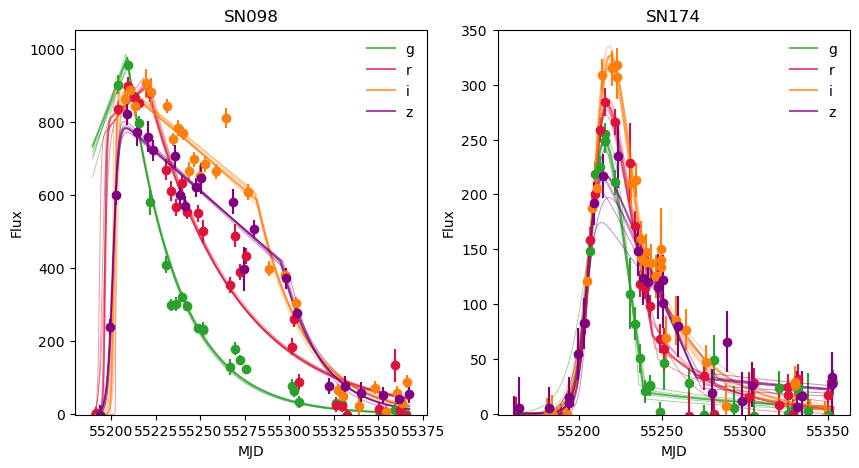

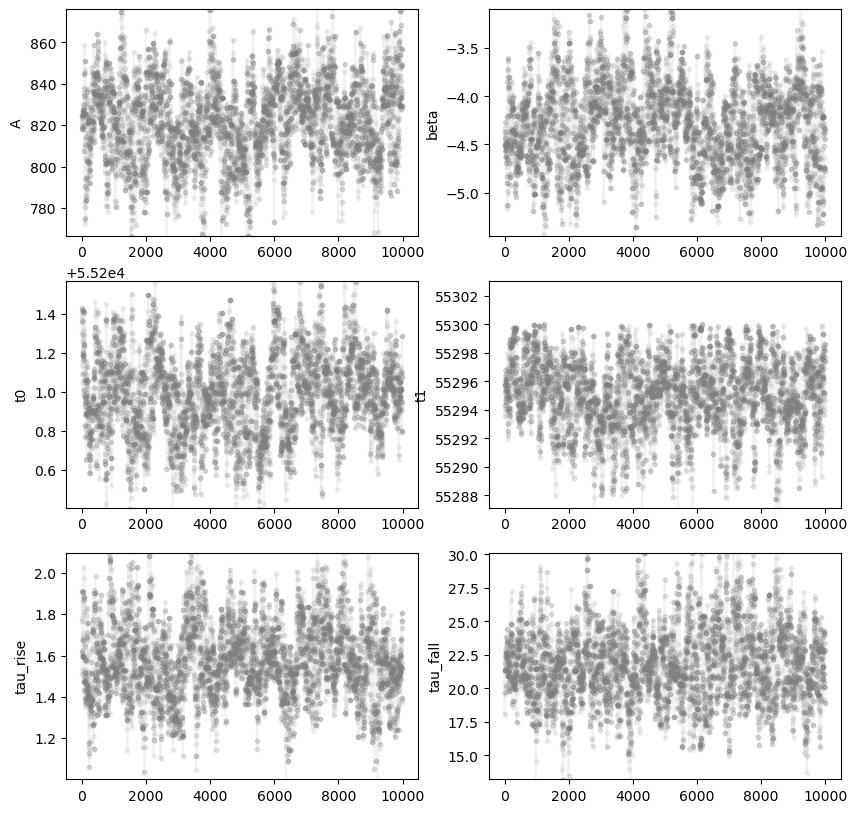

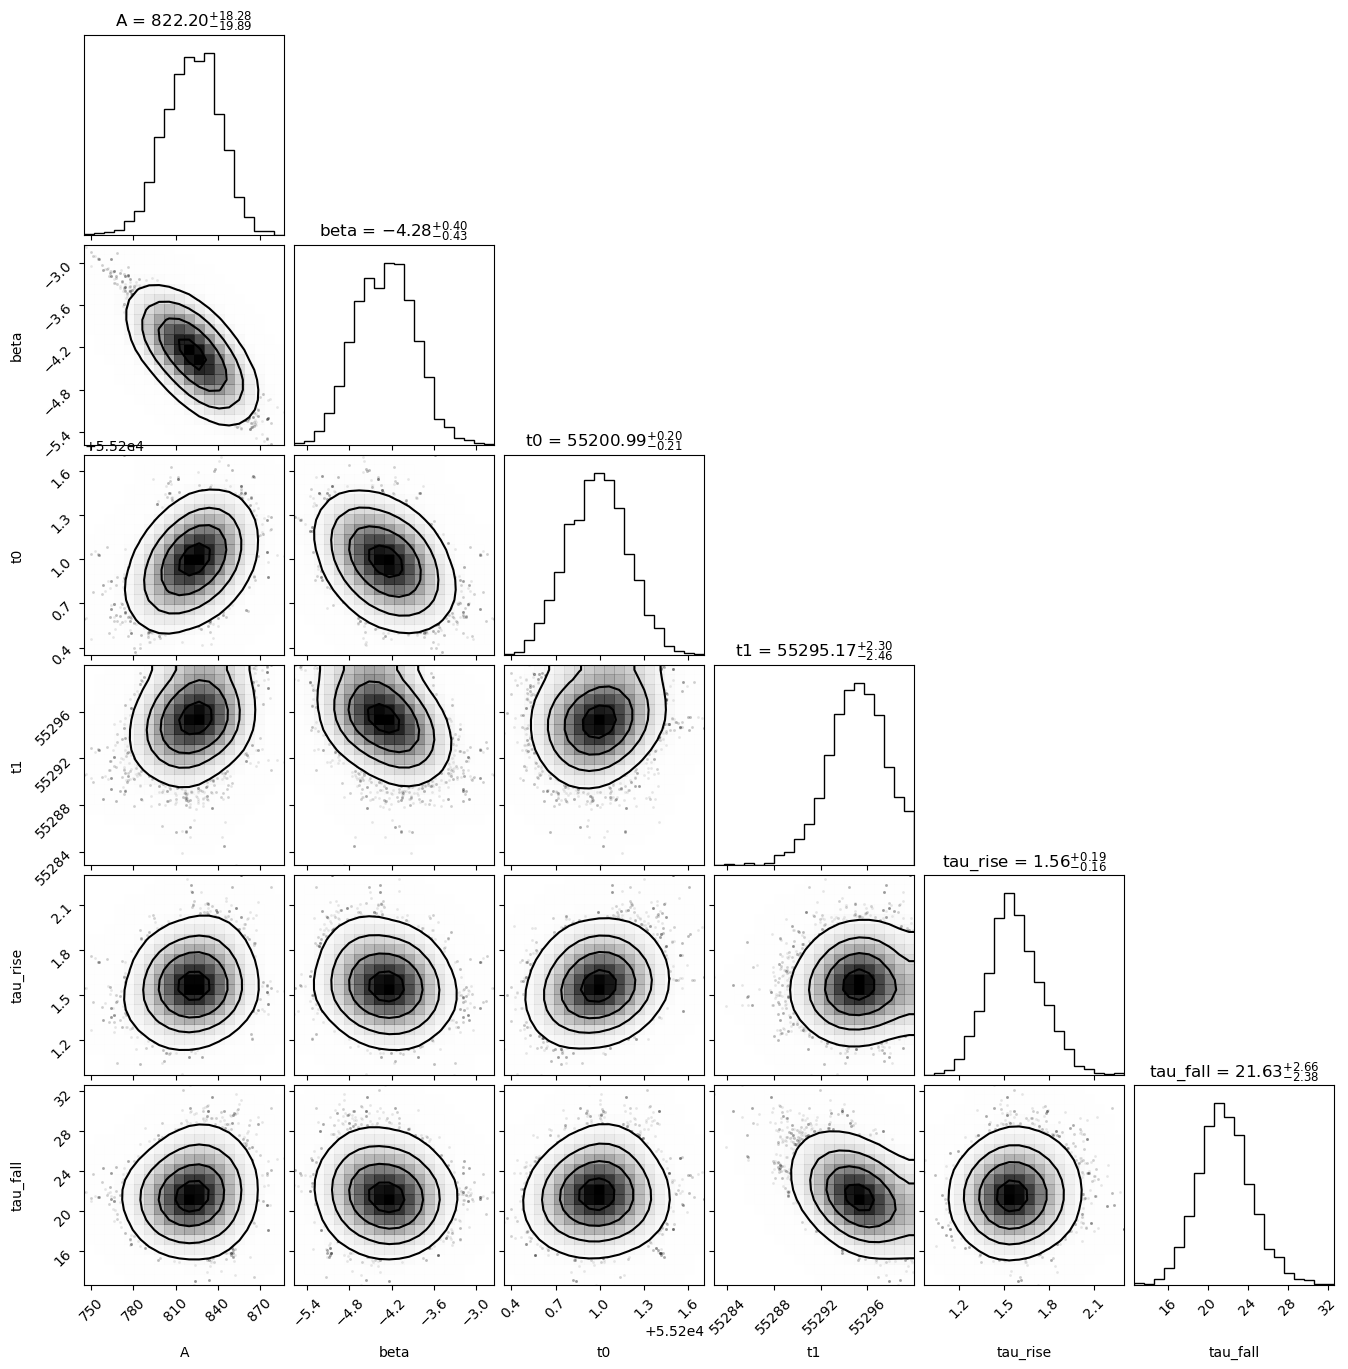

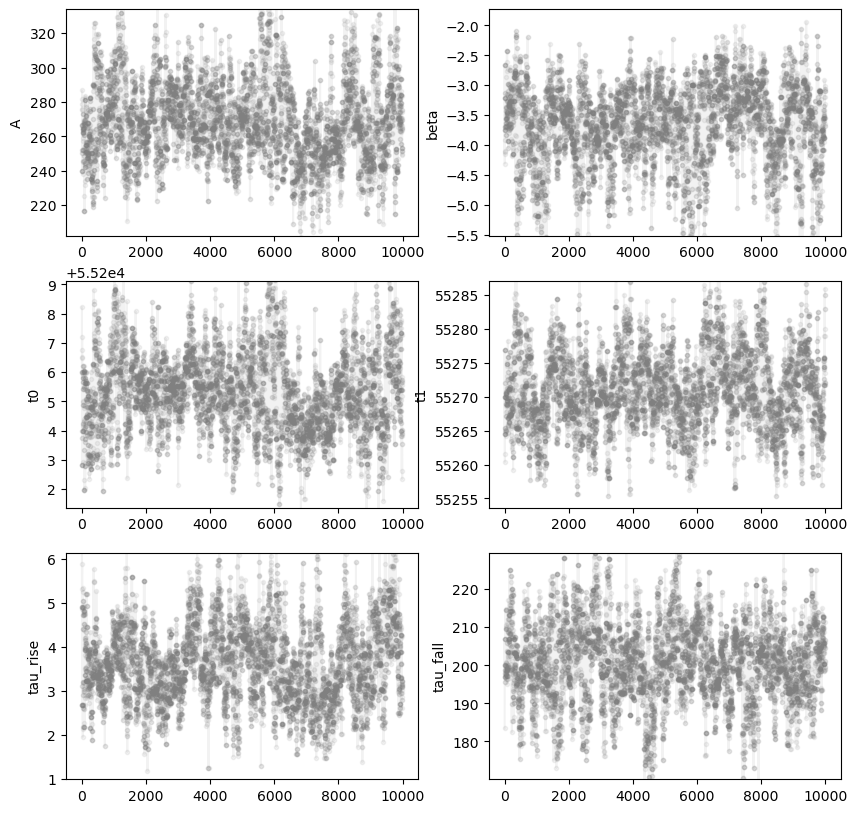

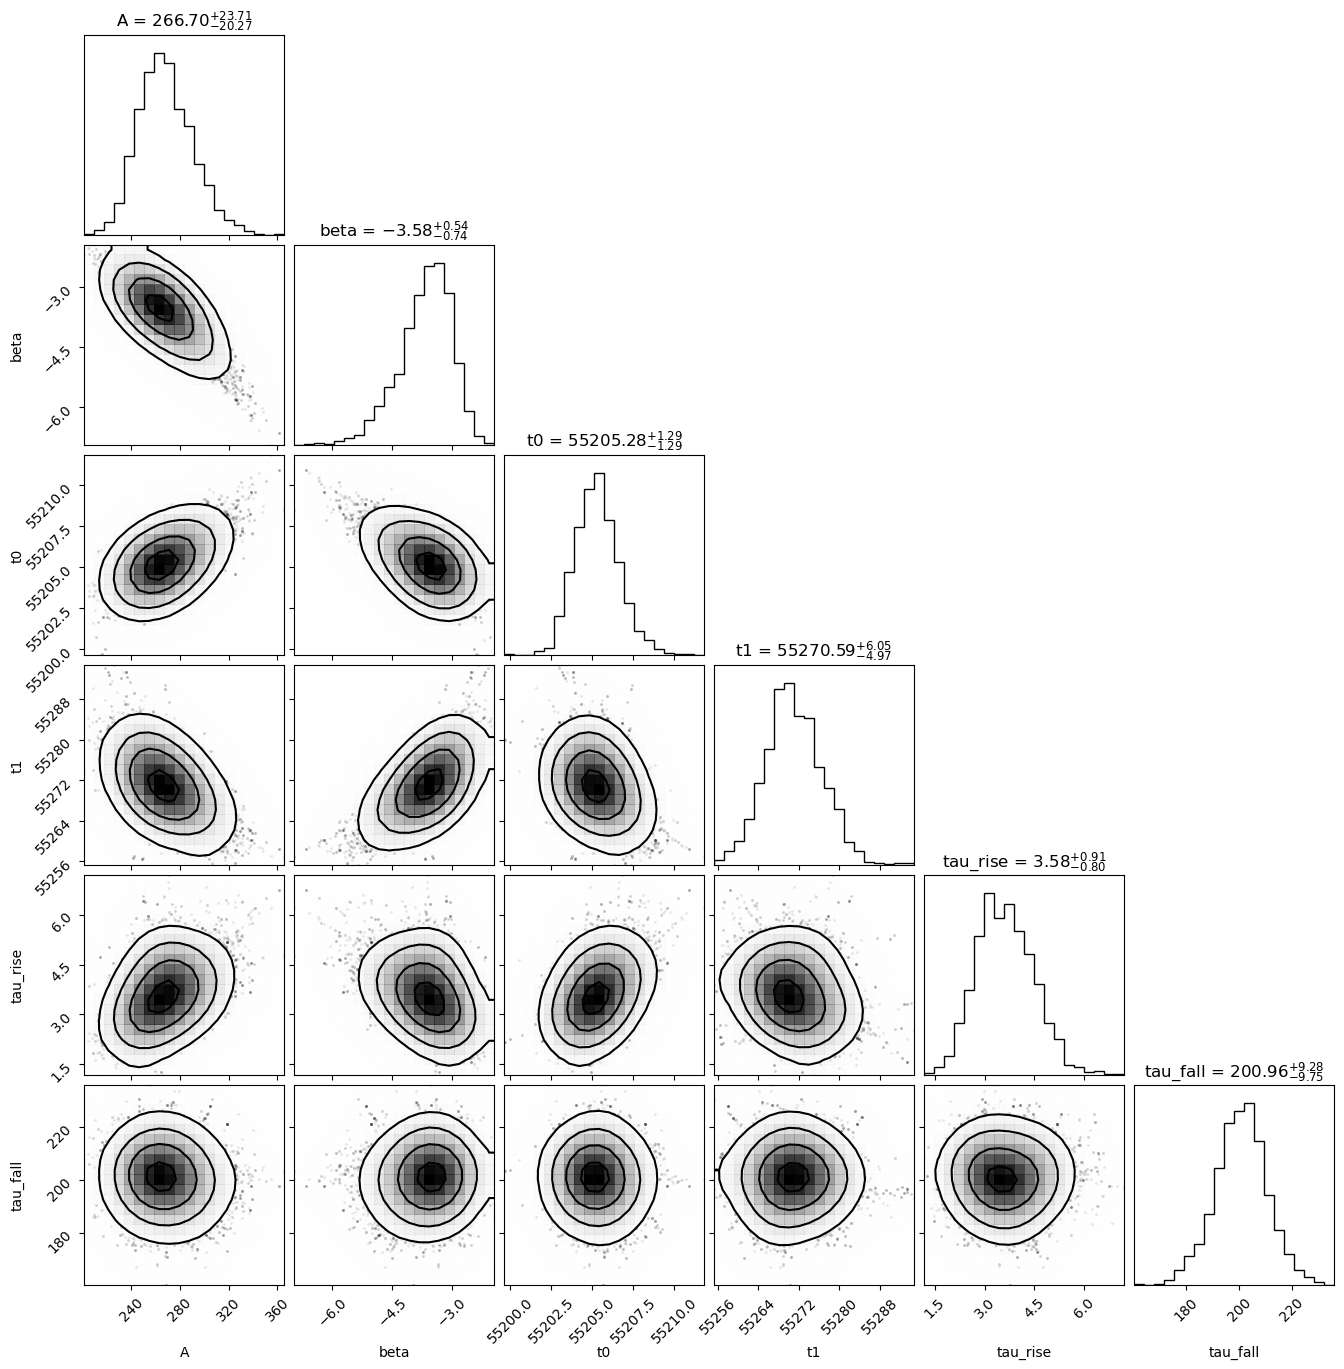

In [10]:
nwalkers = 20
thin = 10
nsteps = 5000
fig1 = plt.figure(figsize=(10, 5))
axs = fig1.subplots(ncols=2)
results_mcmc = {}

for sn, ax, name in zip([sn098, sn174], axs, object_names):
    results_mcmc[name] = {}
    # let's just zoom in on the relevant data - this time for fitting really 
    indmax = sn['FLUXCAL'].argmax()
    mjdmax = sn['MJD'][indmax]
    indshow = (sn['MJD'] > mjdmax-180) & (sn['MJD'] <= mjdmax+180)
    minmjd = sn['MJD'][indshow].min()
    maxmjd = sn['MJD'][indshow].max()
    ax.set_xlim(minmjd-10, maxmjd+10)
    ax.set_ylim(-1, 1.1*sn['FLUXCAL'][indmax])
    
    # setup an array of times on which to plot the model 
    tarr = np.linspace(minmjd, maxmjd, 1000)

    for filt, color in uniq_filts.items():
        indf = sn['FLT'][indshow] == filt
        
        # we need to pass the data to scipy.optimize
        kwargs = {'t':sn['MJD'][indshow][indf],\
                  'y':sn['FLUXCAL'][indshow][indf],
                  'dy':sn['FLUXCALERR'][indshow][indf],
                  'res':results[name][filt]}
        
        guess = results[name][filt].x
        sigmas = np.diag(results[name][filt].hess_inv.todense())**0.5
        
        # we'll initialize the walkers in a small ball around our best fit position 
        # they'll meander away in the next step
        p0 = np.array(guess) + 0.01*sigmas*np.random.randn(nwalkers, ndim)
        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior, kwargs=kwargs )
        state = sampler.run_mcmc(p0, 500) # do a little burn-in - note that this may not be enough 
        sampler.reset()                   # you should check your traceplot at the end to decide
                                          # but it's a way to start the walkers off in more random locations 
                                    
        # run the chain in production
        sampler.run_mcmc(state, nsteps, progress=True)
        samples = sampler.get_chain(flat=True)
        results_mcmc[name][filt] = sampler
        
        mcmc_res = np.percentile(samples[100::thin,:], [50, 16, 84], axis=0)
        res = mcmc_res[0]
        print(name, filt, ' '.join(['%.2f'%x for x in res]))
        
        # plot the data again
        ax.errorbar(sn['MJD'][indshow][indf], sn['FLUXCAL'][indshow][indf], yerr=sn['FLUXCALERR'][indshow][indf],\
                    marker='o', color=color, linestyle='None')
        
        # we'll only plot if the fit was OK
        f = villar_model(*res, t = tarr)
        ax.plot(tarr, f, color=color, linestyle='-', marker='None', alpha=0.7, label=filt)
        draws = np.random.choice(list(range(len(samples))), 5, replace=False)
        for d in draws:
            draw = samples[d]
            fp = villar_model(*draw, t = tarr)
            ax.plot(tarr, fp, color=color, linestyle='-', marker='None', alpha=0.45,  lw=0.7)
    
        if filt == 'z':
            fig2, axsc = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
            labels=['A', 'beta', 't0', 't1', 'tau_rise', 'tau_fall']
            for i in range(samples.shape[1]):
                j, k = np.unravel_index(i, (3,2))
                axc = axsc[j][k]
                axc.plot(samples[100::thin,i], linestyle='-', color='grey', marker='.', alpha=0.1)
                med = np.median(samples[:,i])
                std = np.std(samples[:,i])
                axc.set_ylim(med-3*std, med+3*std) 
                axc.set_ylabel(labels[i])
                
            fig3 = corner.corner(samples[100::thin,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
            
            autocorr_nothin = emcee.autocorr.integrated_time(samples, c=5, tol=50, quiet=True)
            autocorr_thin = emcee.autocorr.integrated_time(samples[::thin], c=5, tol=50, quiet=True)
            print(f'Autocorrelation length without thinning {autocorr_nothin[0]:.3f}  and with thinning {autocorr_thin[0]:.3f}')
            
                                                   
    # add our axes decoration
    ax.legend(loc='upper right', frameon=False)
    ax.set_title(name)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')
    fig.autofmt_xdate()